# Exploring Superfund Site Data

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping

import warnings
warnings.simplefilter(action='ignore')

In [2]:
#change default figure size
plt.rcParams['figure.figsize'] = (20, 10)

Use command line to first convert Superfund Data downloaded in an Esri Geodatabase format into a shapefile,

`ogr2ogr -f "ESRI Shapefile" superfund-sites SuperfundSites.gdb`

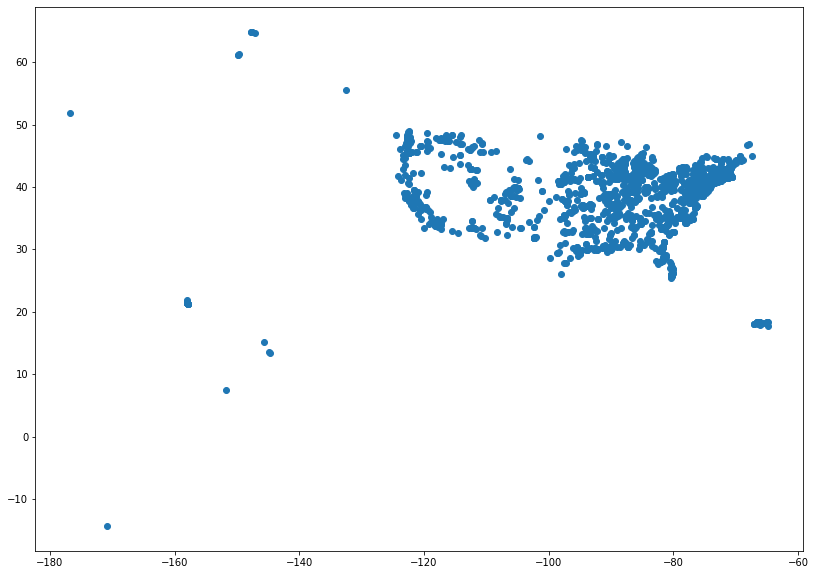

In [3]:
#read superfund site shapefile in
gdf = gpd.read_file('data/superfund-sites/SuperfundSites.shp')

#plot data to visualize
%matplotlib inline
gdf.plot(figsize=(20,10));

In [4]:
#inspect attribute table
gdf.sample(10)

,siteID,EPASiteID,EPARegion,siteName,streetAddr,cityName,state,zipCode,countyName,FIPSCode,congressio,nationalPr,nonNationa,federalFac,geometry
1316,600216,ARD980745665,6,Midland Products,1/2 MI E on Highway 10,Ola/Birta,AR,72853,Yell,5149.0,2.0,Currently on the Final NPL,None,N,POINT (-93.20388 35.02500)
327,200995,NJD980785638,2,Cinnaminson Township (Block 702) Ground Water ...,"1017 Union Landing Road, 1017 Union Landing Road",Cinnaminson Township,NJ,08077,Burlington,34005.0,3.0,Currently on the Final NPL,None,N,POINT (-74.98620 40.01750)
719,302894,WVD004336749,3,Follansbee,Near Bench Mark 681,Follansbee,WV,26037,Brooke,54009.0,1.0,Deleted from the Final NPL,None,N,POINT (-80.60693 40.34028)
415,201877,NYD980528657,2,Olean Well Field,Lauren St,Olean,NY,14760,Cattaraugus,36009.0,23.0,Currently on the Final NPL,None,N,POINT (-78.40471 42.06943)
1793,902092,CAD980818512,9,San Gabriel Valley (Area 2),Sunset & San Bernardino Freeway,Baldwin Park,CA,91706,Los Angeles,6037.0,NaN,Currently on the Final NPL,None,N,POINT (-117.93610 34.07361)
1636,800384,MTD021997689,8,Mouat Industries,Adjacent to air strip in CY,Columbus,MT,59019,Stillwater,30095.0,0.0,Currently on the Final NPL,None,N,POINT (-109.24178 45.62842)
1944,701290,MOD980686281,7,Oronogo-Duenweg Mining Belt,Various Locations,Joplin,MO,64801,Jasper,29097.0,7.0,Currently on the Final NPL,None,N,POINT (-94.42056 37.10111)
996,406487,GA0001401967,4,Georgia Power - Proposed Substation,Highway 27 Ross Road,Brunswick,GA,31520,Glynn,13127.0,1.0,Site is Part of NPL Site,None,N,POINT (-81.50917 31.19000)
1077,502332,MID006013049,5,PMC Groundwater,200 W Lake St,Petoskey,MI,49770,Emmet,26047.0,1.0,Currently on the Final NPL,None,N,POINT (-84.96400 45.37600)
713,302859,VA6210020321,3,Fort Eustis (US Army),End of Mulberry Island,Newport News,VA,23604,Newport News City,51700.0,3.0,Currently on the Final NPL,None,Y,POINT (-76.57833 37.16500)


In [5]:
#inspect national priority status further
gdf['nationalPr'].unique()

array(['Currently on the Final NPL', 'Proposed for NPL',
       'Site is Part of NPL Site', 'Deleted from the Final NPL',
       'Removed from Proposed NPL', 'Withdrawn from the Final NPL'],
      dtype=object)

I received a few warnings about field names truncating when converting the geodatabase to a shapefile, but I can still make out most of the field names except for "nonNationa". 

Unfortunately there is not a whole lot of data here. We have basic location information (EPA region, site name, address, county, etc.) but no data on what type of threats each site poses.

The field "nationalPr" is worth paying attention to, as this lets us know which sites are 'active'. This field tells us whether the site is proposed for NPL, currently on NPL, or deleted or withdrawn from NPL. According to the EPA's [Superfund Site](https://www.epa.gov/superfund/superfund-national-priorities-list-npl), "The National Priorities List (NPL) is the list of sites of national priority among the known releases or threatened releases of hazardous substances, pollutants, or contaminants throughout the United States and its territories." Sites are deleted from the NPL if the EPA "...determines that no further response is required to protect human health or the environment."  I can consider filtering out the deleted sites, or at least differentiating between these when mapping them.

In [6]:
#create subsets of data to explore sites based on their NPL status
current = gdf[(gdf['nationalPr'] == 'Currently on the Final NPL') | (gdf['nationalPr'] == 'Site is Part of NPL Site')]
proposed = gdf[(gdf['nationalPr'] == 'Proposed for NPL')]
deleted = gdf[(gdf['nationalPr'] == 'Deleted from the Final NPL') | (gdf['nationalPr'] == 'Withdrawn from the Final NPL') | (gdf['nationalPr'] == 'Removed from Proposed NPl')]

print("Current NPL sites: ", current.shape[0])
print("Proposed for NPL: ", proposed.shape[0])
print("Deleted or Withdrawn from NPL: ", deleted.shape[0])

Current NPL sites:  1711
Proposed for NPL:  55
Deleted or Withdrawn from NPL:  397


<function print>

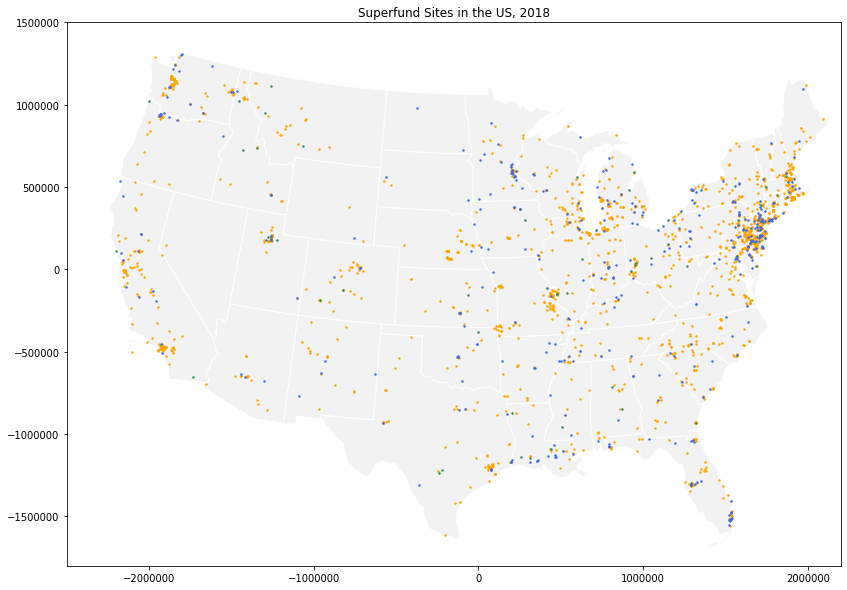

In [7]:
#plot superfund sites based on NPL status over state basemap to visualize distribution
states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')

#project each layer to Albers Equal Conic for visualization
states_equal = states.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
current_equal = current.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
proposed_equal = proposed.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
deleted_equal = deleted.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

#plot projected data
fig, ax = plt.subplots(figsize=(20,10))

states_equal.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0)
current_equal.plot(ax=ax, color='orange', zorder=1, markersize=2);
proposed_equal.plot(ax=ax, color='seagreen', zorder=1, markersize=2);
deleted_equal.plot(ax=ax, color='royalblue', zorder=1, markersize=2);


ax.set(xlim=(-2500000,2200000), ylim=(-1800000,1500000), title='Superfund Sites in the US, 2018');

print